### Проект: Анализ данных в задаче кредитного скоринга

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import scipy
from scipy import stats
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import statistics
import itertools
from statsmodels.stats.proportion import proportion_confint


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
DATA_=pd.read_csv('credit_card_default_analysis.csv')

#### Значения признаков

<br><b>LIMIT_BALЮ</b>: размер кредитного лимита (в том числе и на семью клиента)
<br><b>SEX</b>: пол клиента (1 = мужской, 2 = женский )
<br><b>EDUCATION</b>: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
<br><b>MARRIAGE</b>: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
<br><b>AGE</b>: возраст в годах
<br><b>PAY_0 - PAY_6</b>: История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
<br><b>BILL_AMT1 - BILL_AMT6</b>: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
<br><b>PAY_AMT1 - PAY_AMT6</b>: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
<br><b>default</b> - индикатор невозврата денежных средств

In [5]:
DATA_.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
DATA_.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [7]:
DATA_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


### Задание №1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [8]:
DATA_.default.unique()

array([1, 0], dtype=int64)

In [9]:
DATA_.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

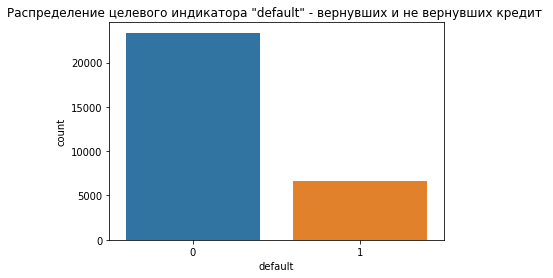

In [10]:
sns.countplot(x='default', data=DATA_)
pylab.title('Распределение целевого индикатора "default" - вернувших и не вернувших кредит ')
pylab.show()


In [11]:
data_LIM_0=DATA_.loc[DATA_.default==0, 'LIMIT_BAL']
print (data_LIM_0.shape) #размер первой группы людей - вернули кредит
data_LIM_1=DATA_.loc[DATA_.default==1, 'LIMIT_BAL']
print (data_LIM_1.shape) #размер второй группы людей - не вернули кредит

(23364,)
(6636,)


In [12]:
data_LIM_0.describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [13]:
data_LIM_1.describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

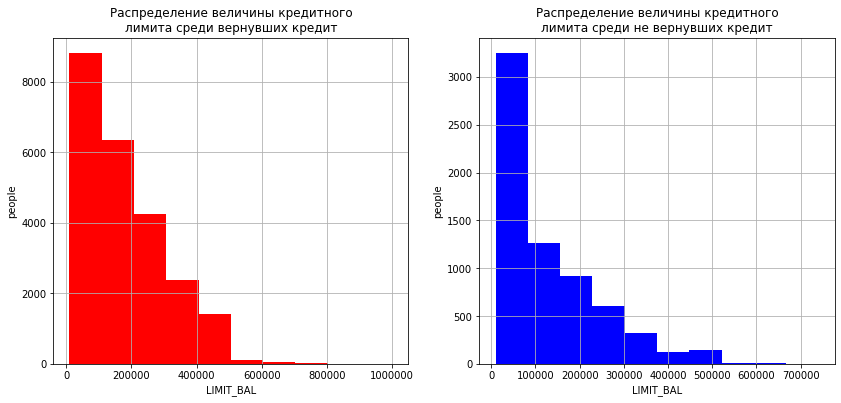

In [14]:
pylab.figure(figsize=(14,6))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data_LIM_0,color = 'r')
pylab.xlabel('LIMIT_BAL')
pylab.ylabel('people')
pylab.title('Распределение величины кредитного'+'\n'+'лимита среди вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data_LIM_1, color = 'b')
pylab.xlabel('LIMIT_BAL')
pylab.ylabel('people')
pylab.title('Распределение величины кредитного'+'\n'+'лимита среди не вернувших кредит')

pylab.show()

### Задача 1.а

#### Проверка гипотез
<br>a) о равенстве медианных значений кредитного лимита с помощью подходящей <br>интервальной оценки</br>


#### точечная оценка выборочных медиан

In [15]:
print (data_LIM_0.shape)
print (data_LIM_1.shape)

(23364,)
(6636,)


In [16]:
# точечные оценки медианы
print (np.median(data_LIM_0))
print (np.median(data_LIM_1))

150000.0
90000.0


 Покажем с помощью критерий Шапиро-Уилака, что значения кредитного лимита в наших выборках распределены не $нормально$ (это наглядно видно на графиках)

Критерий Шапиро-Уилка:

$H0$:  значения кредитного лимита в наших выборках распределены нормально 

$H1$:  не нормально

In [17]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_LIM_0))
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_LIM_1))

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


C:\Users\hadjd\Anaconda2\envs\p37\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Уровень значимсоти полученный с помощью критерия ШУ для обеих групп равен 0, следовательно
можно отклонить 0-ую гипотезу о нормальности распределения исходных выборок на уровне значимости p=0. (но нужно иметь в виду, что сам метод ШУ имеет встроенные ограничения уровня применимости, при N>5000, точность p может снижаться; дополнительную проверку не проводим, т.к. то, что распределения не имеют нормального характера очевидно из исходных графиков)
Следовательно для получения интервальной оценки и проверки 0-гипотезы мы не можем применять t-критерий Стьюдента. Воспользуемся bootstrap.

#### интервальные оценки для медианы с помощью bootstrap

Чтобы построить доверительный интервал для любой статистики нужно знать ее
<b>выборочные распределение</b>, которое мы можем получить с помощью метода bootstrap.

In [18]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
# мы хотим сгенерировать заданное количество подвыборок (n_samples)
# из исходноый выборки, которую передаем в виде аргумента data
# подвыборки генерируем в виде индексов из исходного доступного диапазона

In [19]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
# функция, считающая интервальную оценку статистики

In [20]:
np.random.seed(0)

data_LIM_0_median_scores = list(map(np.median, get_bootstrap_samples(data_LIM_0.values, 10000)))
data_LIM_1_median_scores = list(map(np.median, get_bootstrap_samples(data_LIM_1.values, 10000)))

print("95% доверительный интервал для медианной оценки кредитного лимита для 1ой группы людей:",
      stat_intervals(data_LIM_0_median_scores, 0.05) )
print("95% доверительный интервал для медианной оценки кредитного лимита для 2ой группы людей:",  
      stat_intervals(data_LIM_1_median_scores, 0.05))

95% доверительный интервал для медианной оценки кредитного лимита для 1ой группы людей: [150000. 150000.]
95% доверительный интервал для медианной оценки кредитного лимита для 2ой группы людей: [80000. 90000.]



Проверим гипотезу

$H0$: медианные значения кредитного лимита в первой и второй группах равны

$H1$: медианные значения кредитного лимита в первой и второй группах не равны (двухстороння альетрантива)

### Вывод 1:
Полученные 95%-ые доверитльные интервалы для медиан не пересекаются, следовательно можно сделать вывод о том, что гипотеза H0 отвергается на уровне значимости 5%.

#### точечная оценка разности выборочных медиан

In [21]:
print("разница между медианами:", np.median(data_LIM_0) - np.median(data_LIM_1))

разница между медианами: 60000.0


#### интервальная оценка разности медиан

In [43]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(data_LIM_0_median_scores, data_LIM_1_median_scores)))
print("95% доверительный интервал для разности медиан:",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для разности медиан: [60000. 70000.]


### Вывод 2:
<br>Также мы получили 95%-ый доверительный интервал для разности медиан, данный интервал не содержит 0, исходя из чего, мы также можем сделать вывод, что медианы не равны и отклонить гипотезу H0 на уровне значимости 5%.
<br>



### Задача 1.б

#### Проверка гипотез
<br>b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.</br>



### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Можем воспользоватсья универсальным критерием Манна-Уитни для проеверки гипотезы:
<br><b>H0</b>: функции распределения из которых были получены выборки для 1ой и 2ой группы полностю совпадают
<br><b>H1</b>: функции распределения из которых были получены выборки для 1ой и 2ой группы совпадают с точностбью до аддитивного параметра дельта, который не равен 0. (т.е. распределения сдвинуты друг относительно друга, следовательно не равны друг другу)

In [22]:
stats.mannwhitneyu(data_LIM_0, data_LIM_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

### Вывод

Уровень значимости для критерия Манна-Уитни равен ≈ 6e-190, следовательно мы отклоняем 0-вую гипотезу на уровне значиомости 0.05 в пользу альтернативной, о том, что распределения не равны.

### Вывод о практической значисти

Мы получили <b>статистически значимые</b> отличия в медианных значениях кредитного лимита для 2 групп
людей, которые вернули и не вернули кредит на уровне значимости <b>6e-190</b> (Критерий Манна-Уитни). Точечная выборочная оценка разницы медиан
составила <b>60 000</b> условных единиц. Уровень значимости показывает нам вероятность получить
такую оценку случайно (сделать ошибку 1ого рода), она стремится к нулю, следовательно
<b>размер эффекта</b> (степень отклонения от 0-гипотезы, которую мы уверенно отвергаем) <b>очень сильный</b>.
Но не смотря на очень сильный размер эффекта, разница в медианных значениях не позволяет нам сделать какой-либо <b>практический вывод</b> и установить <b>практическую значимость</b> данных различий.
<br>Ниже приведены два boxplot графика для соответствующих групп людей, по которым мы можем сказать, что межквартильное расстояние для крдитного лимита у второй группы несколько уже и смещенно от соответствуюего расстояния для первой группы, но сделать какие-то качественные оценки о различиях не представляется возможным.



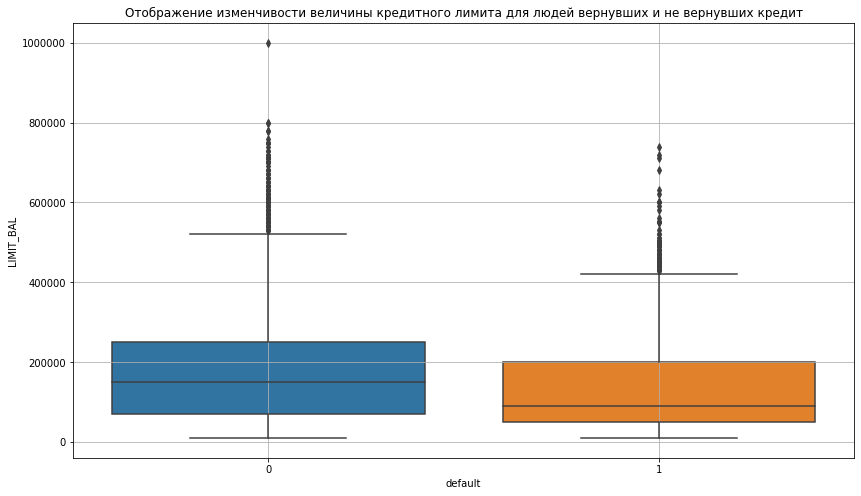

In [23]:
pylab.figure(figsize=(14,8))
sns.boxplot(x='default',y='LIMIT_BAL',data=DATA_)
pylab.title('Отображение изменчивости величины кредитного лимита для людей вернувших и не вернувших кредит')
pylab.grid()
pylab.show()

### Задание№ 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [24]:
data_SEX_0=DATA_.loc[DATA_.default==0, 'SEX']
print (data_SEX_0.shape) #размер первой группы людей - вернули кредит
data_SEX_1=DATA_.loc[DATA_.default==1, 'SEX']
print (data_SEX_1.shape) #размер второй группы людей - не вернули кредит

(23364,)
(6636,)


In [25]:
print (data_SEX_0.value_counts())
print (data_SEX_1.value_counts())

2    14349
1     9015
Name: SEX, dtype: int64
2    3763
1    2873
Name: SEX, dtype: int64


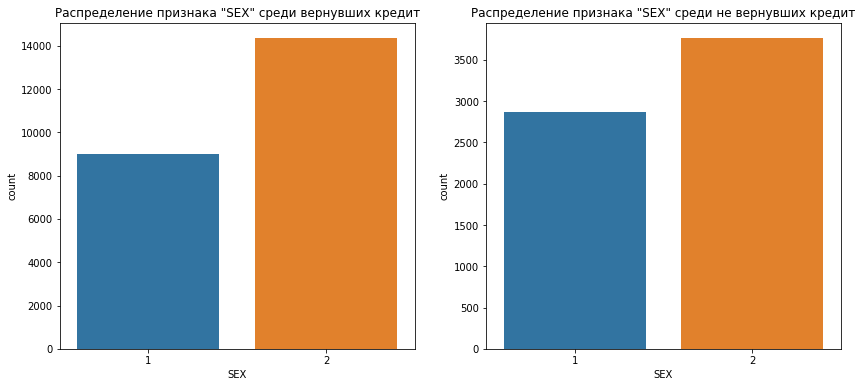

In [26]:
fig, axs = pylab.subplots(figsize=(14, 6) ,nrows=1, ncols=2)

sns.countplot(data_SEX_0,ax=axs[0])
sns.countplot(data_SEX_1,ax=axs[1])
axs[0].set_title('Распределение признака "SEX" среди вернувших кредит')
axs[1].set_title('Распределение признака "SEX" среди не вернувших кредит')
pylab.show()


In [27]:
print (data_SEX_0.value_counts())

2    14349
1     9015
Name: SEX, dtype: int64


Проверка гипотез с помощью интервальной оценки

<br><b>H0</b>: гендерный состав группы людей вернувших и не вернувших кредит не отличается (доля мужчин в 1ой и 2ой группах одинакова - не меняется)
<br><b>H1</b>: гендерный состав группы людей вернувших и не вернувших кредит отличается (доли мужчин в 1ой и 2ой группе не равны)

### Точечная оценка долей

Построим доверительные интервалы для доли мужчин в каждой группе

In [54]:
#истинные значения долей
MALE_SHARE_in_data_SEX_0=data_SEX_0[data_SEX_0==1].shape[0]/data_SEX_0.shape[0]
print ('доля мужчин в первой группе (те кто вернули) %f' %MALE_SHARE_in_data_SEX_0,)
MALE_SHARE_in_data_SEX_1=data_SEX_1[data_SEX_1==1].shape[0]/data_SEX_1.shape[0]
print ('доля мужчин во второй группе (те кто не вернули) %f' %MALE_SHARE_in_data_SEX_1)
print ('точечная оценка разности долей %f' %abs(MALE_SHARE_in_data_SEX_0-MALE_SHARE_in_data_SEX_1))

доля мужчин в первой группе (те кто вернули) 0.385850
доля мужчин во второй группе (те кто не вернули) 0.432942
точечная оценка разности долей 0.047092


### Интервальные оценки долей

In [28]:
conf_interval_MALE_in_data_SEX_0 = proportion_confint(data_SEX_0[data_SEX_0==1].shape[0], 
                                            data_SEX_0.shape[0],
                                            method = 'wilson')
conf_interval_MALE_in_data_SEX_1 = proportion_confint(data_SEX_1[data_SEX_1==1].shape[0], 
                                            data_SEX_1.shape[0],
                                            method = 'wilson')

print ('95 процентный доверительный интервал для доли мужчин в 1ой группе [%f,%f]' %conf_interval_MALE_in_data_SEX_0)
print ('95 процентный доверительный интервал для доли мужчин в 2ой группе [%f,%f]' %conf_interval_MALE_in_data_SEX_1)

95 процентный доверительный интервал для доли мужчин в 1ой группе [0.379627,0.392110]
95 процентный доверительный интервал для доли мужчин в 2ой группе [0.421062,0.444898]


### Вывод 1

Т.к. 95%-ые интервалы для доли мужчин в каждой группе не пересекаются, то можно сделать
вывод о том, что гендерный состав обеих групп статистически различается с уровнем значимости ниже 5% и отклонить H0 гипотезу на уровне значимости 5%.

Сделаем дополнительную проверку рассчитав доверительный интревал для разности долей.

Воспользуемся формулой доверительного интервала для разности долей двух несвязных выборок.


$$ \hat{p}_1 = \frac{a}{n_1}$$


$$ \hat{p}_2 = \frac{b}{n_2}$$

$a$ - количество мужчин в первой выборке

$b$ - количество мужчин во второй выборке

$n_1$ - количество мужчин и женщин в первой выборке

$n_2$ - количество мужчин и женщин в второй выборке


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [29]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = sample1[sample1==1].shape[0]/sample1.shape[0]
    p2 = sample2[sample2==1].shape[0]/sample2.shape[0]
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [30]:
print("95-процентный доверительный интервал для разности долей [%f,%f]:"  %proportions_confint_diff_ind(data_SEX_0,data_SEX_1))

95-процентный доверительный интервал для разности долей [-0.060548,-0.033635]:


### Вывод2
Т.к. 95%-ый интервал для разности доли мужчин в каждой группе не содержит 0, то можно сделать вывод о том, что гендерный состав обеих груп статистически различается с уровнем значимости ниже 5% и отклонить H0 гипотезу на уровне значимости 5%.

### Проверка гипотзы с помощью статистического критерия

<br><b>H0</b>: гендерный состав группы людей вернувших и не вернувших кредит не отличается (доля мужчин в 1ой и 2ой группах одинакова - не меняется)

<br><b>H1</b>: гендерный состав группы людей вернувших и не вернувших кредит отличается (доли мужчин в 1ой и 2ой группе не равны)

Наши выборки принимают 2 значения (мужчина/женщина), следовательно необходимо использовать параметрические
критерии, которые работают с распределениями Бернули.

В нашем случае необходимо использовать <b>Z-критерий для разности долей двух независимых выборок</b>.


$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

$a$ - количество мужчин в первой выборке

$b$ - количество мужчин во второй выборке

$n_1$ - количество мужчин и женщин в первой выборке

$n_2$ - количество мужчин и женщин в второй выборке

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [31]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    
    p1 = sample1[sample1==1].shape[0]/ n1
    p2 = sample2[sample2==1].shape[0]/ n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [32]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [33]:
print("p-value: %g" % proportions_diff_z_test(proportions_diff_z_stat_ind(data_SEX_0, data_SEX_1)))

p-value: 4.47287e-12


### Вывод 3

Гипотеза H0 уверенно отвергается против двусторонней альтернативы, достигаемый уровень значимсоти составляет p-value: 4.47287e-12. Точечная оценка разности двух долей составляет -0.047, 95% доверительный интервал для разности двух долей [-0.060548, -0.033635] 


### Задание №3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

#### Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. 

In [34]:
DATA_.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [35]:
DATA_.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [36]:
DATA_.EDUCATION.isnull().sum()

0

In [37]:
data_EDUC_0=DATA_.loc[DATA_.default==0, 'EDUCATION']
print (data_EDUC_0.shape) #размер первой группы людей - вернули кредит
data_EDUC_1=DATA_.loc[DATA_.default==1, 'EDUCATION']
print (data_EDUC_1.shape) #размер второй группы людей - не вернули кредит

(23364,)
(6636,)


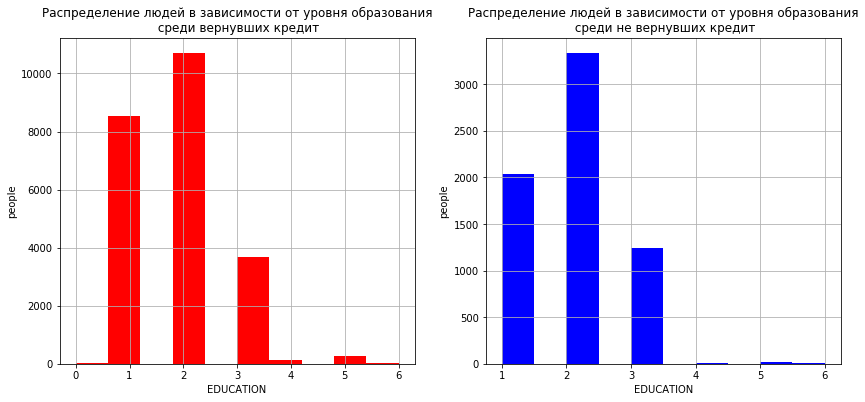

In [38]:
pylab.figure(figsize=(14,6))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data_EDUC_0 ,color = 'r')
pylab.xlabel('EDUCATION')
pylab.ylabel('people')
pylab.title('Распределение людей в зависимости от уровня образования'+'\n'+' среди вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data_EDUC_1, color = 'b',label='111')
pylab.xlabel('EDUCATION')
pylab.ylabel('people')
pylab.title('Распределение людей в зависимости от уровня образования'+'\n'+' среди не вернувших кредит')

pylab.show()

Для двух категориальных переменных мерой силы взаимосвязи (мерой влияния) является <b>коэф. V Крамерра.</b>

Коэф. V Краммера , в свою очередь, определяется через критерий <b>Хи-квадрат</b>, который проверяет значимость отличия от нуля соответствующего коэф. V Краммера.
Строим таблицу сопряженности размером 6x2

<b>Проверим гипотезу:</b>

<br><b>H0</b>: Образование не влияет на то, вернет ли чеовек долг (т.е. между уровнем образования и целевым индикатором возврата / невозврата денежных средств нет взаимосвязи(корреляции)

<br><b>H1</b>: Образование влияет на то, вернет ли чеовек долг (т.е. между уровнем образования и целевым индикатором возврата / невозврата денежных есть взаимосвязь(корреляция). (двусторонняя альтернатива)

составим табилцу сопряженности

In [39]:
table=pd.crosstab(DATA_.EDUCATION, DATA_.default)
table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [40]:
chi2, p_value, n_dof, expected_values= chi2_stat=scipy.stats.chi2_contingency(table)
n=table.sum().sum()
min_from_shape=min(table.shape[0],table.shape[1])
V_Krammer=np.sqrt(chi2/(n*(min_from_shape-1)))
print ('коэффициент Краммера = ',V_Krammer)
print ('p_value = ',p_value)

коэффициент Краммера =  0.07376009713252163
p_value =  1.2332626245415605e-32


проверим соответствие условию применимости критерия Хи-квадрат
1. n>=40
2. expected_values [i][j] < 5 не более, чем в 20% ячеек

In [41]:
n

30000

In [42]:
expected_values

array([[1.0903200e+01, 3.0968000e+00],
       [8.2435980e+03, 2.3414020e+03],
       [1.0926564e+04, 3.1034360e+03],
       [3.8293596e+03, 1.0876404e+03],
       [9.5792400e+01, 2.7207600e+01],
       [2.1806400e+02, 6.1936000e+01],
       [3.9718800e+01, 1.1281200e+01]])

In [43]:
print (expected_values[expected_values<5])
print (expected_values.shape[0]*expected_values.shape[1])
print ('в',round ( 1/(expected_values.shape[0]*expected_values.shape[1])*100, 2), '% ячеек ожидаемое количество элементов меньше 5')

[3.0968]
14
в 7.14 % ячеек ожидаемое количество элементов меньше 5


### Вывод 1

С помощью критерия Хи-Квадрат мы получили значение коэф. V-Краммера = 0.07376 с уровнем значимости p_value = 1.2e-32, следовательно мы уверенно отвергаем 0-ую гипотезу в пользу альтернативной, и делаем вывод, что полученный коэф. Краммера значимо отличается от 0, что указывает на статистически значимую корреляцию между уровнем образования и вовратом или невовзратом денежных средств.

Предложите способ <b>наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг</b>.
Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?

1. Окргулим ожидаемые значения до целых (т.к. мы считаем людей)

In [44]:
expected_values

array([[1.0903200e+01, 3.0968000e+00],
       [8.2435980e+03, 2.3414020e+03],
       [1.0926564e+04, 3.1034360e+03],
       [3.8293596e+03, 1.0876404e+03],
       [9.5792400e+01, 2.7207600e+01],
       [2.1806400e+02, 6.1936000e+01],
       [3.9718800e+01, 1.1281200e+01]])

In [45]:
expected_values_round=[list(map(lambda x: round(x),i)) for i in expected_values]
expected_values_round

[[11.0, 3.0],
 [8244.0, 2341.0],
 [10927.0, 3103.0],
 [3829.0, 1088.0],
 [96.0, 27.0],
 [218.0, 62.0],
 [40.0, 11.0]]

In [46]:
table_diff=table.values-expected_values_round
table_diff

array([[   3.,   -3.],
       [ 305., -305.],
       [-227.,  227.],
       [-149.,  149.],
       [  20.,  -20.],
       [  44.,  -44.],
       [   3.,   -3.]])

Данную таблицу можно отмасштабировать следующим образом: каждое значение можно разделить на сумму
всех человек с соответствующим образованием, так мы получим долю или процент, 
на который каждое наблюдаемое значение отличается от ожидаемого, относительно всего количества людей с данным образованием, это поможет нам оценить для какого уровня образования данные различия преоблдают.

In [47]:
sum_by_educ=[DATA_.EDUCATION[DATA_.EDUCATION==i].count() for i in range(7)]
print (sum_by_educ)

[14, 10585, 14030, 4917, 123, 280, 51]


In [48]:
#альтернативный способ
DATA_.EDUCATION.value_counts(sort=False)

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

Для первой группы:

In [49]:
table_diff.T[0]

array([   3.,  305., -227., -149.,   20.,   44.,    3.])

In [50]:
table_diff_0=np.array([0.,0.,0.,0.,0.,0.,0.])
for number,el in enumerate(table_diff.T[0]):

    table_diff_0[number]=round(int(el)/sum_by_educ[number],4)
print (table_diff_0)


[ 0.2143  0.0288 -0.0162 -0.0303  0.1626  0.1571  0.0588]


Для второй:

In [51]:
table_diff_1=np.array([0.,0.,0.,0.,0.,0.,0.])
for number,el in enumerate(table_diff.T[1]):

    table_diff_1[number]=round(el/sum_by_educ[number],4)
print (table_diff_1)

[-0.2143 -0.0288  0.0162  0.0303 -0.1626 -0.1571 -0.0588]


In [52]:
table_diff_modern=np.vstack((table_diff_0,table_diff_1)).T
table_diff_modern

array([[ 0.2143, -0.2143],
       [ 0.0288, -0.0288],
       [-0.0162,  0.0162],
       [-0.0303,  0.0303],
       [ 0.1626, -0.1626],
       [ 0.1571, -0.1571],
       [ 0.0588, -0.0588]])

### Вывод 2
По таблицы разницы между наблюдаемыми и ожидаемыми значениями можно сделать вывод, что

1) Среди тех, кто вернули кредит, наибольшая разница между ожидаемым и наблюдаемым значениями
соответствует людям с 0-образованием (Доктора). Наблюдаем на 20% больше.

2) Среди тех, кто не вернул кредит,  наибольшая разница между ожидаемым и наблюдаемым значениями
соответствует людям с 0-образованием (Доктора). Наблюдаем на 20% меньше. 

Комментарии:

Практическая значимость из данного сравнения не совсем очевидена.

<b>Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?</b>

1. Рассмотрим таблицу сопряженности для наблюдаемых значений


In [53]:
table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


2. Посчитаем для каждой группы соответствующую долю успехов для каждого вида образования

(для 1ой группы - долю вернувших, для 2ой-долю невернувших)

In [54]:
table['sum']=table[0]+table[1]
table
print ([table.iloc[i,0]/table['sum'][i] for i in range(7)])
print ([table.iloc[i,1]/table['sum'][i] for i in range(7)])

[1.0, 0.8076523382144544, 0.7626514611546685, 0.7484238356721579, 0.943089430894309, 0.9357142857142857, 0.8431372549019608]
[0.0, 0.19234766178554558, 0.23734853884533144, 0.2515761643278422, 0.056910569105691054, 0.06428571428571428, 0.1568627450980392]


In [55]:
print ([table.iloc[i,1]/table['sum'][i] for i in range(7)])

[0.0, 0.19234766178554558, 0.23734853884533144, 0.2515761643278422, 0.056910569105691054, 0.06428571428571428, 0.1568627450980392]


3. В качетве метрики для оценки наилучшего индикатора 

а) возврата кредита

будем использовать левую границу 95%-го доверительного интервала для доли , посчитпнного по методу Уилсона. (выбираем наивысшую из нижних границ доли возвратов, т.е. как минимум данная доля на уровне доверия 95% вернет кредит)

б) невозврата кредита

будем использовать правую границу 95%-го доверительного интервала для доли , посчитпнного по методу Уилсона. (выбираем наивысшую из верхних границ долю невозвратов, т.е. максимальная доля невозвратов на уровне доверия 95%)

In [56]:
conf_int_0=[proportion_confint( table.iloc[i,0], table['sum'][i], method = 'wilson') 
            for i in range(7)]
conf_int_0

[(0.7846891972623641, 0.9999999999999999),
 (0.8000326702900069, 0.8150487836470102),
 (0.7555401149671762, 0.7696190170941121),
 (0.7361046029027092, 0.7603552039095749),
 (0.8871784587405342, 0.9721620204168744),
 (0.9006819688438781, 0.9589528463581449),
 (0.7198955322701223, 0.918307767799513)]

In [57]:
print ('наибольшее значение левой границы =',max([i[0] for i in conf_int_0]))

наибольшее значение левой границы = 0.9006819688438781


In [58]:
print ('данной границе соответствует уровень образования: ',
       np.where(conf_int_0==max( [i[0] for i in conf_int_0]))[0][0])

данной границе соответствует уровень образования:  5


In [59]:
conf_int_1=[proportion_confint( table.iloc[i,1], table['sum'][i], method = 'wilson')
            for i in range(7)]
conf_int_1

[(2.7755575615628914e-17, 0.21531080273763586),
 (0.1849512163529897, 0.19996732970999295),
 (0.23038098290588793, 0.24445988503282373),
 (0.2396447960904251, 0.2638953970972908),
 (0.02783797958312565, 0.11282154125946578),
 (0.041047153641855086, 0.09931803115612199),
 (0.08169223220048706, 0.2801044677298777)]

In [60]:
print ('наибольшее значение правой границы =' ,max([i[1] for i in conf_int_1]))
print ('данной границе соответствует уровень образования: ',
       np.where(conf_int_1==max([i[1] for i in conf_int_1]))[0][0])

наибольшее значение правой границы = 0.2801044677298777
данной границе соответствует уровень образования:  6


In [61]:
right_border_for0=[i[0] for i in conf_int_0]
left_border_for0=[i[1] for i in conf_int_0]
conf_intervals0=[[right_border_for0[i],left_border_for0[i]] for i in range(7)]
conf_intervals0

[[0.7846891972623641, 0.9999999999999999],
 [0.8000326702900069, 0.8150487836470102],
 [0.7555401149671762, 0.7696190170941121],
 [0.7361046029027092, 0.7603552039095749],
 [0.8871784587405342, 0.9721620204168744],
 [0.9006819688438781, 0.9589528463581449],
 [0.7198955322701223, 0.918307767799513]]

In [62]:
right_border_for1=[i[0] for i in conf_int_1]
left_border_for1=[i[1] for i in conf_int_1]
conf_intervals1=[[right_border_for1[i],left_border_for1[i]] for i in range(7)]
conf_intervals1

[[2.7755575615628914e-17, 0.21531080273763586],
 [0.1849512163529897, 0.19996732970999295],
 [0.23038098290588793, 0.24445988503282373],
 [0.2396447960904251, 0.2638953970972908],
 [0.02783797958312565, 0.11282154125946578],
 [0.041047153641855086, 0.09931803115612199],
 [0.08169223220048706, 0.2801044677298777]]

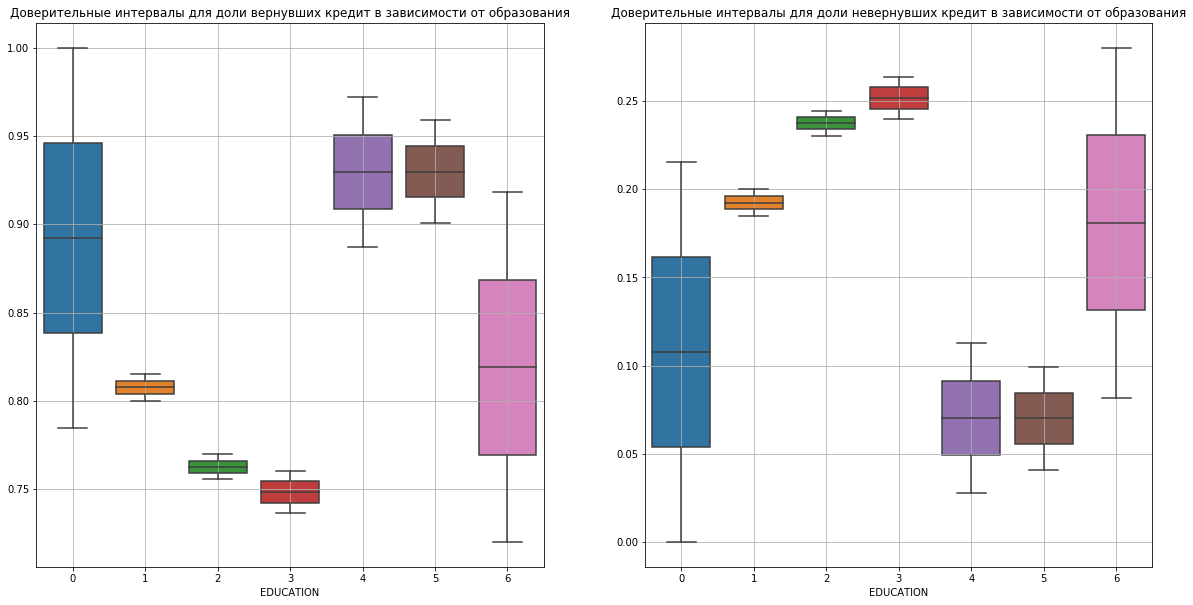

In [63]:
ig, axs = pylab.subplots(figsize=(20, 10) ,nrows=1, ncols=2)
sns.boxplot(x=np.arange(7),y=conf_intervals0,ax=axs[0])
sns.boxplot(x=np.arange(7),y=conf_intervals1,ax=axs[1])
axs[0].set_title('Доверительные интервалы для доли вернувших кредит в зависимости от образования')
axs[1].set_title('Доверительные интервалы для доли невернувших кредит в зависимости от образования')
axs[0].set(xlabel='EDUCATION')
axs[1].set(xlabel='EDUCATION')
axs[0].grid()
axs[1].grid()
pylab.show()

### Вывод 3

1. Наилучший индикатор того, что человек вернет деньги - образование 5 (прочее) - наивысшая из нижних границ, т.е. для этого типа образования минимальная доля вернувших наибольшая среди долей для других видов образований с уровнем доверия 95%.
2. Наилучший индикатор того, что человек не вернет деньги - образование 6 (нет данных). - наивысшая из верхних границ, т.е.для этого типа образования максимальная доля невернувших кредит - наибольшая среди долей для других видов образований с уровнем доверя 95%.

### Задание №4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [64]:
DATA_.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [65]:
DATA_.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

Оба признака - категоральные, используем коэф. V Крамера для оценки степени взаимосвязи.
Значимость полученного значения проверяем метрикой Хи-квадрат.

<b>Проверим гипотезу:</b>

<br><b>H0</b>: Семейный статус не влияет на то, вернет ли человек долг (т.е. между семейным статусом и целевым индикатором возврата / невозврата денежных средств нет взаимосвязи(корреляции)

<br><b>H1</b>: Семейный статус влияет, вернет ли чеовек долг (т.е. между семейным статусом и целевым индикатором возврата / невозврата денежных есть взаимосвязь(корреляция). (двусторонняя альтернатива)

In [66]:
table_MAR_def=pd.crosstab(DATA_.MARRIAGE, DATA_.default)
table_MAR_def


default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [67]:
chi2_M, p_value_M, n_dof_M, expected_values_M= chi2_stat=scipy.stats.chi2_contingency(table_MAR_def)
n=table_MAR_def.sum().sum()
min_from_shape=min(table_MAR_def.shape[0],table_MAR_def.shape[1])
V_Krammer_M=np.sqrt(chi2_M/(n*(min_from_shape-1)))
print ('коэффициент Краммера = ',V_Krammer_M)
print ('p_value = ',p_value_M)

коэффициент Краммера =  0.034478203662766466
p_value =  8.825862457577375e-08


проверим соответствие условию применимости критерия Хи-квадрат
1. n>=40
2. expected_values [i][j] < 5 не более, чем в 20% ячеек

In [68]:
n

30000

In [69]:
expected_values_M

array([[4.20552000e+01, 1.19448000e+01],
       [1.06376292e+04, 3.02137080e+03],
       [1.24327632e+04, 3.53123680e+03],
       [2.51552400e+02, 7.14476000e+01]])

In [70]:

print ('ячейки, где ожидаемое значение ниже 5-',expected_values_M[expected_values_M<5])
print (expected_values_M.shape[0]*expected_values_M.shape[1])
print ('в',round ( 0/(expected_values_M.shape[0]*expected_values_M.shape[1])*100, 2), '% ячеек ожидаемое количество элементов меньше 5')

ячейки, где ожидаемое значение ниже 5- []
8
в 0.0 % ячеек ожидаемое количество элементов меньше 5


### Вывод 1

С помощью критерия Хи-Квадрат мы получили значение коэф. V-Краммера = 0.034 с уровнем значимости p_value = 8.8e-08, следовательно мы уверенно отвергаем 0-ую гипотезу в пользу альтернативной, и делаем вывод, что полученный коэф. Краммера значимо отличается от 0, что указывает на <b>статистически значимую корреляцию</b> между семейным статусом и вовратом или невовзратом денежных средств.

Т.е. семейный статус связан с индикатором дефолта статистически значимо, мера связи - коэф. V Крамера = 0.034. Коэф. крамера имеет малое значение, находится близко к левой границе, которая равна 0 и соответствует отсутствию взаимосвязи между факторами, следовательно делаем вывод, что связь слабая.

### Задание №5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### Задача 5 а

#### Проверка гипотез
<br>a) о равенстве медианных значений возраста относительно двух групп людей вернувших и не вернувших кредит

In [71]:
DATA_[['AGE']].describe()

,AGE
count,30000.000000
mean,35.485500
std,9.217904
min,21.000000
25%,28.000000
50%,34.000000
75%,41.000000
max,79.000000


In [72]:
data_age_0=DATA_.loc[DATA_.default==0, 'AGE']
print (data_age_0.shape)
data_age_1=DATA_.loc[DATA_.default==1, 'AGE']
print (data_age_1.shape)

(23364,)
(6636,)


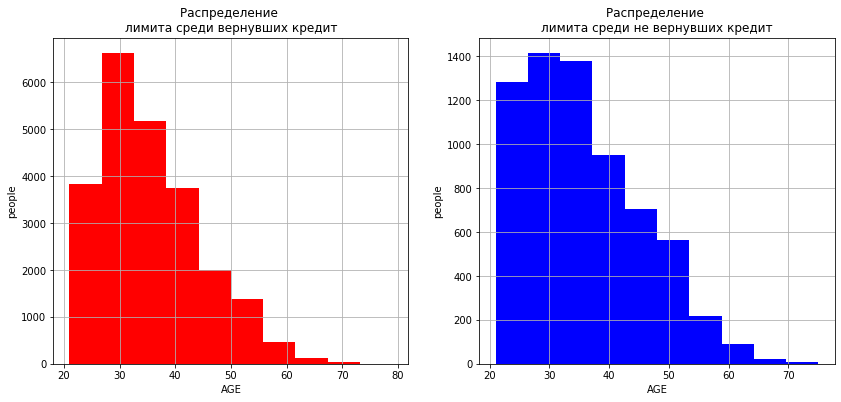

In [73]:
pylab.figure(figsize=(14,6))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data_age_0,color = 'r')
pylab.xlabel('AGE')
pylab.ylabel('people')
pylab.title('Распределение '+'\n'+'лимита среди вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data_age_1, color = 'b')
pylab.xlabel('AGE')
pylab.ylabel('people')
pylab.title('Распределение '+'\n'+'лимита среди не вернувших кредит')

pylab.show()

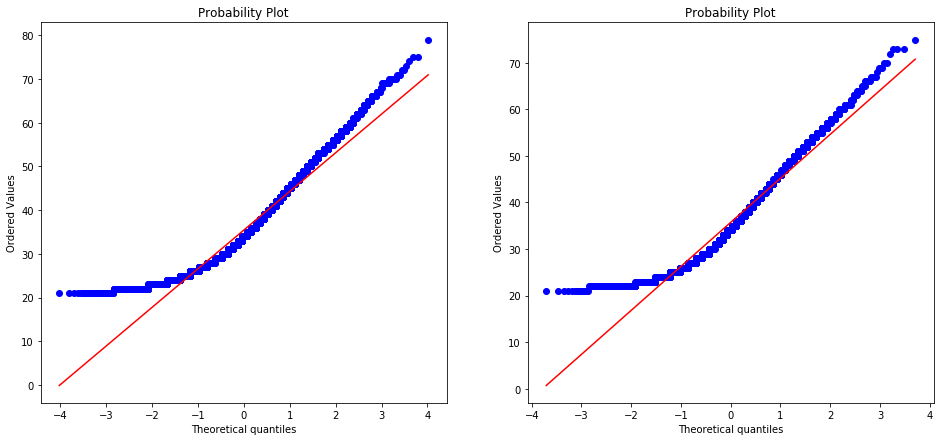

In [74]:
pylab.figure(figsize(16,7))
pylab.subplot(121)
scipy.stats.probplot(data_age_0,plot=pylab)
pylab.subplot(122)
scipy.stats.probplot(data_age_1,plot=pylab)
pylab.show()

In [75]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(np.log(data_age_0)))
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(np.log(data_age_1)))

Shapiro-Wilk normality test, W-statistic: 0.980914, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.975410, p-value: 0.000000


C:\Users\hadjd\Anaconda2\envs\p37\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


По распределениям признака в каждой группе видно, что оно отличается от нормального.
Графики QQ-plot и проверка критерием Шапиро-Уилака подтвержает отклонение распределений от нормального.



Проверим гипотезу

$H0$: медианные значения возраста людей в первой и второй группах равны

$H1$: медианные значения возраста людей в первой и второй группах не равны (двухстороння альетрантива)

In [76]:
print (np.median(data_age_0))
print (np.median(data_age_1))

34.0
34.0


интервальные оценки медиан с помощью bootstrap

In [77]:
np.random.seed(0)

data_age_0_median_scores = list(map(np.median, get_bootstrap_samples(data_age_0.values, 10000)))
data_age_1_median_scores = list(map(np.median, get_bootstrap_samples(data_age_1.values, 10000)))

print("95% доверительный интервал для медианной оценки кредитного лимита для 1ой группы людей:",
      stat_intervals(data_age_0_median_scores, 0.05) )
print("95% доверительный интервал для медианной оценки кредитного лимита для 2ой группы людей:",  
      stat_intervals(data_age_0_median_scores, 0.05))

95% доверительный интервал для медианной оценки кредитного лимита для 1ой группы людей: [34. 34.]
95% доверительный интервал для медианной оценки кредитного лимита для 2ой группы людей: [34. 34.]


точечная оценка разницы медиан

In [78]:
print("разница между медианами:", np.median(data_age_0) - np.median(data_age_1))

разница между медианами: 0.0


интервальная оценка разности медиан с помощью bootstrap

In [79]:
delta_median_scores_age = list(map(lambda x: x[0] - x[1], zip(data_age_0_median_scores, data_age_1_median_scores)))
print("95% доверительный интервал для разности медиан:",  stat_intervals(delta_median_scores_age, 0.05))

95% доверительный интервал для разности медиан: [-1.  0.]


### Вывод 1:
Интервальные оценки медиан полностью совпадают, а интервальня оценка разности медиан включает 0, следовательно мы не можем отклонить 0-ую гипотезу на уровне значимости 0.05 в пользу альтернативной.

Воспользуемся ранговым критерием. Т.к. выборки независимые, то используем критерий
Манна-Уитни.

Проверим гипотезу

$H0$: медианные значения возраста людей в первой и второй группах равны

$H1$: медианные значения возраста людей в первой и второй группах не равны (двухстороння альетрантива)

In [80]:
stats.mannwhitneyu(data_age_0, data_age_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

### Вывод 2
Критерий Манна-Уитни дает уровень значимости p=0.186, выборочная разность медиан = 0,
95% доверительный интервал для разности медиан равен [-1.  0.], 0-ая гипотеза о равнестве
медиан не отклоняется на уровне значисоит 0.05.

### Задача 5 б

#### Проверка гипотез
<br>a) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

<br><b>H0</b>: функции распределения из которых были получены выборки для 1ой и 2ой группы полностю совпадают
<br><b>H1</b>: функции распределения из которых были получены выборки для 1ой и 2ой группы совпадают с точностбью до аддитивного параметра дельта, который не равен 0. (т.е. распределения сдвинуты друг относительно друга, следовательно не равны друг другу)

In [81]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [82]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [83]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

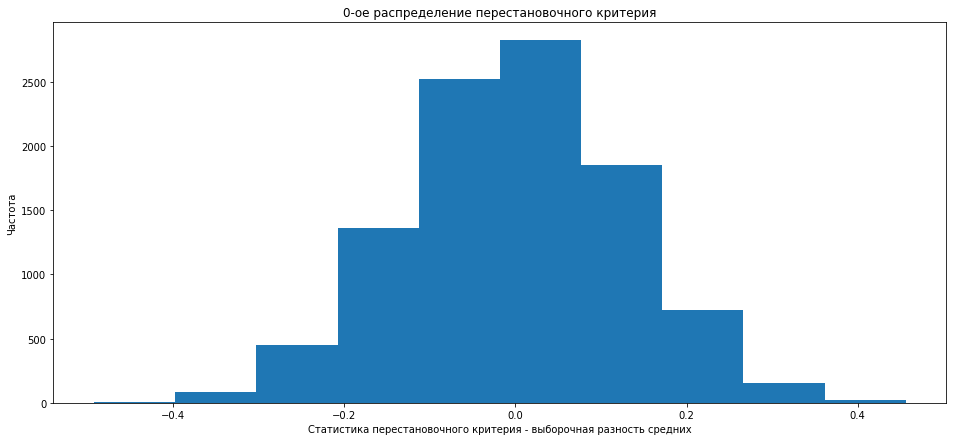

In [84]:
pylab.hist(permutation_zero_dist_ind(data_age_0, data_age_1, max_combinations = 10000),bins=10)
pylab.title('0-ое распределение перестановочного критерия')
pylab.xlabel('Статистика перестановочного критерия - выборочная разность средних')
pylab.ylabel('Частота')
pylab.show()

In [85]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [86]:
print("p-value: %f" % permutation_test(data_age_0, data_age_1, max_permutations = 10000))

p-value: 0.015300


#### Вывод: 
Уровень значимости равен 0.0153, следовательно мы отвергаем 0-ую гипотзу о равенстве распределений в пользу альтернативной.